# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

# import tensorflow as tf
# tf.config.experimental_run_functions_eagerly(True)
# tf.keras.backend.set_floatx('float64')

# import tensorflow.python.util.deprecation as deprecation
# deprecation._PRINT_DEPRECATION_WARNINGS = False

In [2]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import math
import time
import timeit
from   tqdm    import tqdm
import pandas  as pd
import numpy   as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot                        as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow
from   tensorflow.keras.models                  import *
from   tensorflow.keras.layers                  import *
from   tensorflow.keras.callbacks               import *
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User library
#
from utils.PerformanceMetrics import RegressionEvaluation


print('[INFO] Libraries imported')

[INFO] Libraries imported


# Parameters

In [3]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## CUDA

In [4]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)
except:
    print('[INFO] Not GPU found')

## Training paramers

In [5]:
Lag        =   48
Horizon    =   6
#
epochs     =  200
batch_size =   32

Transformation = True

# Importing data

In [6]:
# Parameters
#
filename   = 'metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'

In [7]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.14 seconds


,Date,PM2.5,PM10,NO2,CO
0,2022-01-27 16:12:40,0.5,0.5,75.0,298.0
1,2022-01-27 16:12:56,0.5,0.5,75.0,298.0
2,2022-01-27 16:13:13,0.5,0.5,76.0,298.0


## Preprocess

In [8]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
df = pd.DataFrame( df['PM2.5'] )
df.head(3)

,PM2.5
Date,
2022-01-27 16:10:00,0.477778
2022-01-27 16:15:00,0.463158
2022-01-27 16:20:00,0.715789


In [9]:
targetSeries = df.columns[-1]

## Include MA-based features

In [10]:
df['MA6']  = df[ targetSeries ].rolling(6).mean()
df['MA12'] = df[ targetSeries ].rolling(12).mean()

# df['Hour'] = df.index.hour

## Split Training/Testing set

In [11]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

In [12]:
print('Training: ', df_train.shape[0])
print('Testing:  ', df_test.shape[0])

Training:  9362
Testing:   2344


## Visualize Training & Testing data

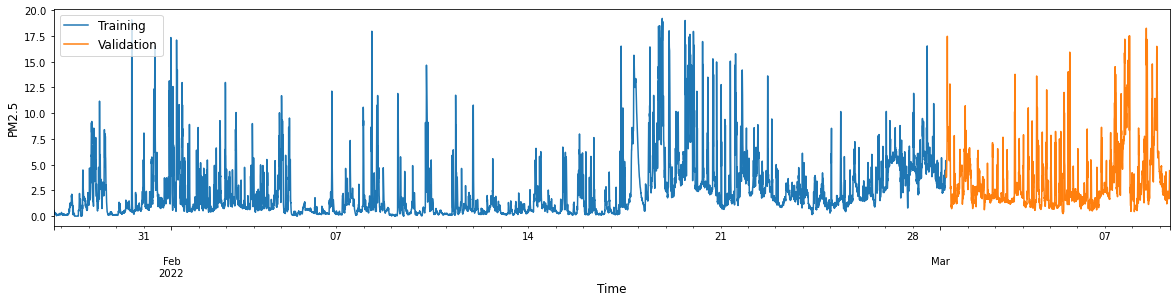

In [13]:
plt.figure( figsize = (20, 4) );
#
df_train[ targetSeries ].plot()
df_test[ targetSeries ].plot()
#
plt.legend(['Training', 'Validation', 'Testing'], fontsize = 12);
plt.ylabel( targetSeries, size = 12);
plt.xlabel( 'Time', size = 12);

## Fix lag

In [14]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Contruction of fitting data for training a forecasting model

### Data Transformation

In [15]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = max(df.min().min(), 1.0)
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


### Data scaling 

In [16]:
for feature in df_train.columns:
    if (feature == targetSeries): continue

    # Setup scaler
    #
    scaler = StandardScaler()

    # Performing Scaling - for each feature
    df_train[feature] = scaler.fit_transform( df_train[feature].to_numpy().reshape(-1,1) )
    df_test[feature]  = scaler.transform( df_test[feature].to_numpy().reshape(-1,1) )


# Setup scaler
#
scaler = StandardScaler()

df_train[targetSeries] = scaler.fit_transform( df_train[targetSeries].to_numpy().reshape(-1,1) )
df_test[targetSeries]  = scaler.transform( df_test[targetSeries].to_numpy().reshape(-1,1) )

### Include date/time features

In [17]:
# df_train['Time (sin)'] = np.sin( df_train.index.hour + df_train.index.minute / 60 )
# df_train['Time (cos)'] = np.cos( df_train.index.hour + df_train.index.minute / 60 )
# #
# df_test['Time (sin)']  = np.sin( df_test.index.hour + df_test.index.minute / 60 )
# df_test['Time (cos)']  = np.cos( df_test.index.hour + df_test.index.minute / 60 )

### Create fitting data 

In [18]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):
        
        dataX.append( df.to_numpy()[i:(i+Lag)] )        
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        
        
    return ( np.array(dataX), np.array(dataY) )

In [19]:
trainX, trainY = create_dataset(df           = df_train, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = 1,)
                               

testX,  testY  = create_dataset(df           = df_test, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = Horizon,)


print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:00<00:00, 107412.08it/s]

Training instances:     9309
Testing instances:       390


In [20]:
trainX.shape, trainY.shape

((9309, 48, 3), (9309, 6))

# Forecasting model

In [21]:
# Define metrics
#
metrics = [
            MeanAbsolutePercentageError(name = "MAPE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]

2022-03-18 00:17:42.368867: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
class ResidualUnit(object):
    """Residual unit block (unidimensional).
    Parameters
    ----------
    n_samples_out: int
        Number of output samples.
    n_filters_out: int
        Number of output filters.
    kernel_initializer: str, optional
        Initializer for the weights matrices. See Keras initializers. By default it uses
        'he_normal'.
    dropout_keep_prob: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. Default is 17.
    preactivation: bool, optional
        When preactivation is true use full preactivation architecture proposed
        in [1]. Otherwise, use architecture proposed in the original ResNet
        paper [2]. By default it is true.
    postactivation_bn: bool, optional
        Defines if you use batch normalization before or after the activation layer (there
        seems to be some advantages in some cases:
        https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md).
        If true, the batch normalization is used before the activation
        function, otherwise the activation comes first, as it is usually done.
        By default it is false.
    activation_function: string, optional
        Keras activation function to be used. By default 'relu'.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027 [cs], Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, n_samples_out, n_filters_out, kernel_initializer='he_normal',
                 dropout_keep_prob=0.8, kernel_size=17, preactivation=True,
                 postactivation_bn=False, activation_function='relu'):
        self.n_samples_out = n_samples_out
        self.n_filters_out = n_filters_out
        self.kernel_initializer = kernel_initializer
        self.dropout_rate = 1 - dropout_keep_prob
        self.kernel_size = kernel_size
        self.preactivation = preactivation
        self.postactivation_bn = postactivation_bn
        self.activation_function = activation_function

    def _skip_connection(self, y, downsample, n_filters_in):
        """Implement skip connection."""
        # Deal with downsampling
        if downsample > 1:
            y = MaxPooling1D(downsample, strides=downsample, padding='same')(y)
        elif downsample == 1:
            y = y
        else:
            raise ValueError("Number of samples should always decrease.")
        # Deal with n_filters dimension increase
        if n_filters_in != self.n_filters_out:
            # This is one of the two alternatives presented in ResNet paper
            # Other option is to just fill the matrix with zeros.
            y = Conv1D(self.n_filters_out, 1, padding='same',
                       use_bias=False, kernel_initializer=self.kernel_initializer)(y)
        return y

    def _batch_norm_plus_activation(self, x):
        if self.postactivation_bn:
            x = Activation(self.activation_function)(x)
            x = BatchNormalization(center=False, scale=False)(x)
        else:
            x = BatchNormalization()(x)
            x = Activation(self.activation_function)(x)
        return x

    def __call__(self, inputs):
        """Residual unit."""
        x, y = inputs
        n_samples_in = y.shape[1]
        downsample = n_samples_in // self.n_samples_out
        n_filters_in = y.shape[2]
        y = self._skip_connection(y, downsample, n_filters_in)
        # 1st layer
        x = Conv1D(self.n_filters_out, self.kernel_size, padding='same',
                   use_bias=False, kernel_initializer=self.kernel_initializer)(x)
        x = self._batch_norm_plus_activation(x)
        if self.dropout_rate > 0:
            x = Dropout(self.dropout_rate)(x)

        # 2nd layer
        x = Conv1D(self.n_filters_out, self.kernel_size, strides=downsample,
                   padding='same', use_bias=False,
                   kernel_initializer=self.kernel_initializer)(x)
        if self.preactivation:
            x = Add()([x, y])  # Sum skip connection and main connection
            y = x
            x = self._batch_norm_plus_activation(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        else:
            x = BatchNormalization()(x)
            x = Add()([x, y])  # Sum skip connection and main connection
            x = Activation(self.activation_function)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
            y = x
        return [x, y]

In [23]:
def get_model(trainX, n_classes, last_layer='linear'):
    
    kernel_size = 2
    kernel_initializer = 'he_normal'
           
    signal = Input(shape = (trainX.shape[1], trainX.shape[2]), dtype=np.float32, name='signal')
    x = signal
#     x = Conv1D(16, kernel_size, padding='same', use_bias=False, kernel_initializer=kernel_initializer)(x)
    x = LSTM(units = 100, activation='relu',return_sequences=True )( x )
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x, y = ResidualUnit(64, 128, kernel_size=kernel_size,
#                         kernel_initializer=kernel_initializer)([x, x])
#     x, y = ResidualUnit(256, 196, kernel_size=kernel_size,
#                         kernel_initializer=kernel_initializer)([x, y])
#     x, y = ResidualUnit(64, 256, kernel_size=kernel_size,
#                         kernel_initializer=kernel_initializer)([x, y])
    x, _ = ResidualUnit(8, 32, kernel_size=kernel_size,
                        kernel_initializer=kernel_initializer)([x, x])
    x = Flatten()(x)
    diagn = Dense(n_classes, activation=last_layer, kernel_initializer=kernel_initializer)(x)
    model = Model(signal, diagn)
    return model


model = get_model(trainX, 6)
# model.summary()

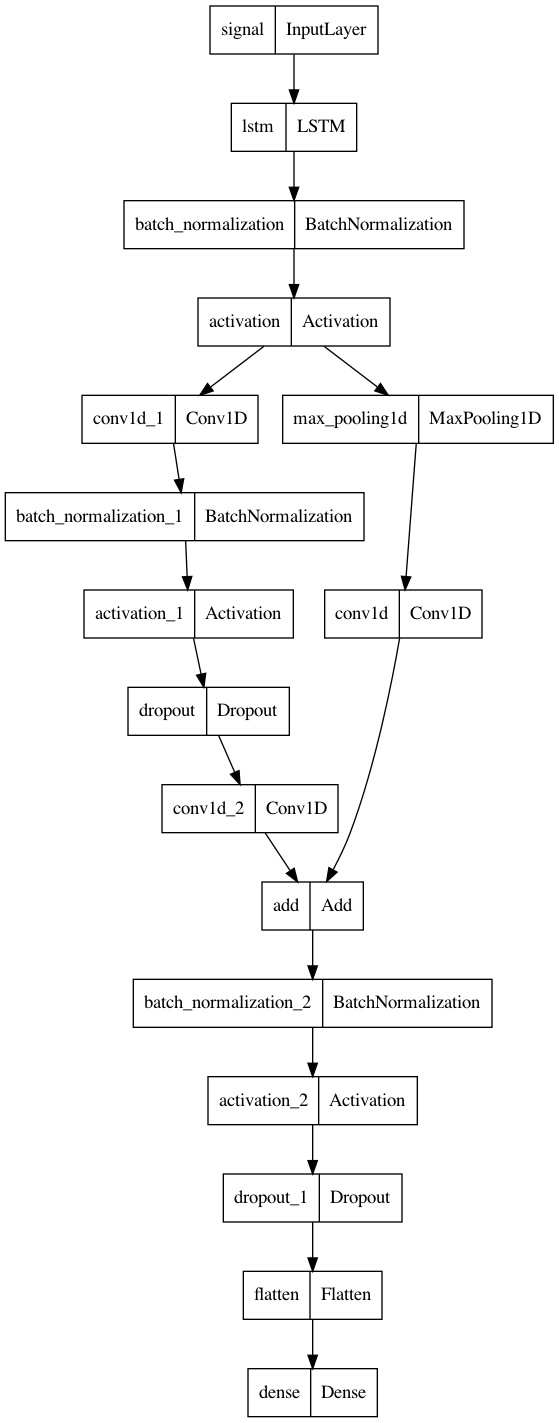

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
#            rankdir='LR',
           expand_nested=False, 
           dpi=96)

## Training forecasting model

In [25]:
# Define metrics
#
metrics = [
            MeanAbsoluteError(name = "MAE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]


model.compile(loss      = 'mse', 
              optimizer = Adam(learning_rate = 5.e-4), 
              metrics   = metrics)

In [26]:
# Checkpoint
#
checkpoint = ModelCheckpoint("models/ResNet.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.5,
                                   patience    = 5)

In [27]:
# Start clock
#
start = timeit.default_timer()


score = model.fit(trainX, trainY, 
                  epochs          = epochs, 
                  batch_size      = batch_size, 
                  callbacks       = [checkpoint, earlystopping, lrs_scheduler],
                  verbose         = 1, 
                  validation_data = (testX, testY))


# Terminate clock
#
stop = timeit.default_timer()

Epoch 1/200
291/291 [==============================] - 7s 21ms/step - loss: 0.7105 - MAE: 0.6377 - RMSE: 0.8429 - val_loss: 0.6091 - val_MAE: 0.5731 - val_RMSE: 0.7804 - lr: 5.0000e-04
Epoch 2/200
291/291 [==============================] - 5s 19ms/step - loss: 0.4757 - MAE: 0.5148 - RMSE: 0.6897 - val_loss: 0.4023 - val_MAE: 0.4668 - val_RMSE: 0.6343 - lr: 5.0000e-04
Epoch 3/200
291/291 [==============================] - 5s 19ms/step - loss: 0.3986 - MAE: 0.4637 - RMSE: 0.6314 - val_loss: 0.4320 - val_MAE: 0.5018 - val_RMSE: 0.6572 - lr: 5.0000e-04
Epoch 4/200
291/291 [==============================] - 6s 19ms/step - loss: 0.3606 - MAE: 0.4358 - RMSE: 0.6005 - val_loss: 0.3217 - val_MAE: 0.4099 - val_RMSE: 0.5672 - lr: 5.0000e-04
Epoch 5/200
145/291 [=============>................] - ETA: 2s - loss: 0.3416 - MAE: 0.4240 - RMSE: 0.5845

KeyboardInterrupt: 

In [ ]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 3) )

# Plot RMSE
#
ax[0].plot( score.history['RMSE']);
ax[0].plot( score.history['val_RMSE']);
ax[0].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[0].set_title('RMSE');

# Plot RMSE
#
ax[1].plot( score.history['MAE']);
ax[1].plot( score.history['val_MAE']);
ax[1].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[1].set_title('MAE');

## Load optimized forecasting model

In [ ]:
# Load the best model
#
model.load_weights('models/ResNet.hdf5')

# Evaluation

## Get predictions

In [ ]:
# Get predictions
#
pred = model.predict( testX )

## Apply inverse scaling/transformation

In [ ]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred = np.exp( pred )   - VALUE

## Visualization of predictions

In [ ]:
Results = dict()

for i in range( Horizon ):
    Prices = pd.DataFrame( [] )

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
    

        
    # Store results
    #
    Results[ 'Horizon {}'.format(i+1) ] = Prices

    
    
    
    # Plot results
    #
    plt.figure( figsize = (20, 4) );
    #
    Prices[ targetSeries ][:100].plot(color = 'tab:blue', marker = 'o')
    Prices[ 'Prediction' ][:100].plot(color = 'tab:orange', marker = 'o')
    
    #
    #
    plt.legend([targetSeries, 'Prediction'], fontsize = 12, frameon=False);
    plt.ylabel(targetSeries, size = 12 );
    plt.xlabel('Time', size = 12);
    plt.show()

## Regression evaluation

In [ ]:
sResults = {'MAE': [], 'RMSE': [], 'MAPE': [], 'SMAPE': [], 'R2': []}

for i in range(Horizon):
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Results['Horizon {}'.format(i+1)] )
    
    sResults['MAE']   += [MAE]
    sResults['RMSE']  += [RMSE]
    sResults['MAPE']  += [MAPE]
    sResults['SMAPE'] += [SMAPE]
    sResults['R2']    += [R2]
    
    
#     print('Horizon -%i-' % (i+1))
#     print('--------------')
#     print('MAE   = %.3f' % MAE)
#     print('RMSE  = %.3f' % RMSE)
#     print('MAPE  = %.3f' % MAPE)
#     print('SMAPE = %.3f' % SMAPE)
#     print('R2    = %.3f' % R2)
#     print()
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' %(i+1, MAE, SMAPE, R2) )

In [ ]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
    
            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices[targetSeries] - Prices['Prediction']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )       

## Examples

In [ ]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [113, 75, 141, 325, 139, 185, 188, 27, 31]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

In [ ]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    plt.grid()
#     plot_scatter(range(0, Lag),             testX[i,:Lag], color='b')
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

# Store predictions

In [ ]:
Outputs = pd.DataFrame( [] )


Outputs[ targetSeries ] = testY.flatten()
Outputs['Seq2Seq_LSTM'] = pred.flatten()

Outputs.to_csv('Predictions/ResNet.csv')

# 